# Addressing Overfitting by Data Augmentation

Data augmentation is a technique used in Machine Learning and Computer Vision to artificially increase the size of a dataset by applying various transformations to the existing data:

1. **Rotation**: Rotating the image by a certain angle.
2. **Translation**: Shifting the image horizontally or vertically.
3. **Scaling**: Resizing the image, either enlarging or shrinking it.
4. **Flipping**: Mirroring the image horizontally or vertically.
5. **Shearing**: Distorting the image by shifting one side of the image either horizontally or vertically.
6. **Zooming**: Enlarging a portion of the image while keeping the overall image size constant.
7. **Color Jittering**: Randomly adjusting brightness, contrast, saturation, and hue of the image.
8. **Noise Injection**: Adding random noise to the image.
9. **Crop and Pad**: Cropping or padding the image to a different size.
10. **Elastic Deformation**: Applying elastic transformations to the image to simulate deformations.

Data augmentation is particularly useful in scenarios where the size of the training dataset is limited or when the model needs to be robust to various transformations in real-world scenarios. By augmenting the dataset, the model learns to generalize better and becomes more invariant to variations in the input data.

In deep learning, data augmentation is commonly used in tasks such as image classification, object detection, and semantic segmentation. It helps in improving the performance of models, especially when the training data is limited or when there is a class imbalance. Additionally, data augmentation can also aid in regularization, helping prevent overfitting by introducing variations in the training data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL  ## Pillow Library
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-05-02 09:03:44.799529: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 09:03:44.799643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 09:03:44.991460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Looking around the Dataset

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir: Storing Directory
# untar: unzip

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [4]:
list(data_dir.glob('*/*.jpg'))[:5]  # Gets all the images in all the directories

[PosixPath('datasets/flower_photos/roses/15699509054_d3e125286f_n.jpg'),
 PosixPath('datasets/flower_photos/roses/12243069253_e512464095_n.jpg'),
 PosixPath('datasets/flower_photos/roses/269037241_07fceff56a_m.jpg'),
 PosixPath('datasets/flower_photos/roses/8462246855_1bdfee7478.jpg'),
 PosixPath('datasets/flower_photos/roses/5181899042_0a6ffe0c8a_n.jpg')]

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [6]:
roses = list(data_dir.glob('roses/*'))  # Getting all the rose images from its folder
roses[:5]

[PosixPath('datasets/flower_photos/roses/15699509054_d3e125286f_n.jpg'),
 PosixPath('datasets/flower_photos/roses/12243069253_e512464095_n.jpg'),
 PosixPath('datasets/flower_photos/roses/269037241_07fceff56a_m.jpg'),
 PosixPath('datasets/flower_photos/roses/8462246855_1bdfee7478.jpg'),
 PosixPath('datasets/flower_photos/roses/5181899042_0a6ffe0c8a_n.jpg')]

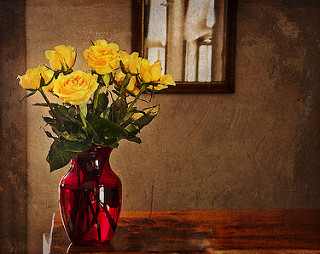

In [7]:
PIL.Image.open(str(roses[1]))

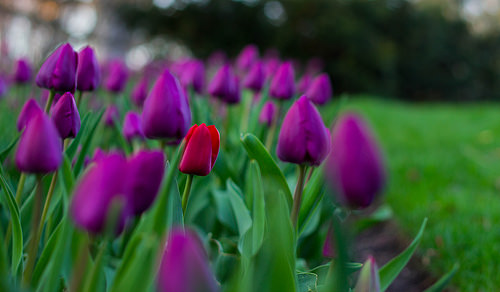

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

# Reading All the Images

In [9]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [10]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/15699509054_d3e125286f_n.jpg'),
 PosixPath('datasets/flower_photos/roses/12243069253_e512464095_n.jpg'),
 PosixPath('datasets/flower_photos/roses/269037241_07fceff56a_m.jpg'),
 PosixPath('datasets/flower_photos/roses/8462246855_1bdfee7478.jpg'),
 PosixPath('datasets/flower_photos/roses/5181899042_0a6ffe0c8a_n.jpg')]

In [11]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [12]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(213, 320, 3)

The `cv2.resize()`, below cell, function resizes the image to fit the specified dimensions without cropping by default. It performs resizing by either stretching or shrinking the image to match the new dimensions.

In [13]:
cv2.resize(img, (180,180)).shape

(180, 180, 3)

Now, we do the resize on all the images, and create data with its corresponding output on each datapoint.

In [14]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [15]:
X = np.array(X)
y = np.array(y)

# Train/Test Split
Next, we will split the data to create our required Training and Test data.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

# Preprocessing: scale images 
Bringing the range of data into [0, 1]

In [17]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

# Building CNN Model
Below code, defines convolutinal neural network model for the image. 

In [18]:
num_classes = 5

model = Sequential([
    ## Convolutions
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
  
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    ## Network
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.fit(X_train_scaled, y_train, epochs=30) ## For saving time, we did it with only 3 epochs

Epoch 1/30
10/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2982 - loss: 1.7488

I0000 00:00:1714640662.990223      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714640663.006196      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3825 - loss: 1.4800
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6020 - loss: 1.0055
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6791 - loss: 0.8530
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7904 - loss: 0.5982
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8672 - loss: 0.3936
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9225 - loss: 0.2560
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9641 - loss: 0.1250
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9790 - loss: 0.0862
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9807 - loss: 0.0707
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9871 - loss: 0.0615
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9947 - loss: 0.0285
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9941 - l

A great accuracy on the training dataset!

In [19]:
model.evaluate(X_test_scaled, y_test)

16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6683 - loss: 1.8854

W0000 00:00:1714640710.354072      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6638 - loss: 1.9361


[2.004552125930786, 0.6601307392120361]

However, a very weak accuracy on unseen data, which suggest that the model is overfitted to the data. We can address this problem using different methods. Here we want to use the Data Augmentation technique to solve this, before that, take a look at the below cell. 

To check the prediction, we need to pass the `X_test_scaled` to the predict method. Then, use a function (or a threshold) to make the decision on based on the probabilties that `predictions` contains. Using `softmax` here is ideal. After that, we use `argmax` to return the corresponding value. Below is an example of this procedure:

In [20]:
predictions = model.predict(X_test_scaled)
score = tf.nn.softmax(predictions[0])
np.argmax(score), y_test[0]

28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

W0000 00:00:1714640713.512026      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


(0, 4)

# Solving the Overfitting problem using Data Augmentation 
Let's solve this overfitting using the Augmentation technique.

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Checking the original and new randomly generated image:

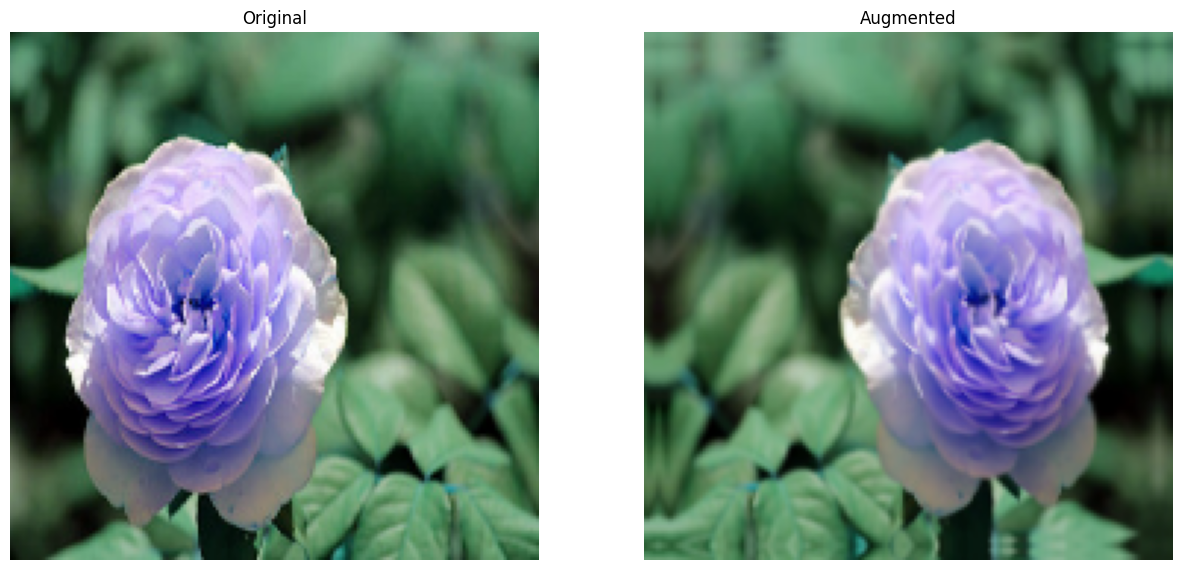

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].axis('off')
ax[0].set_title("Original")
ax[0].imshow(X[0])

ax[1].axis('off')
ax[1].set_title("Augmented")
ax[1].imshow(data_augmentation(X)[0].numpy().astype("uint8"))

plt.show()

# Training again with Augmentation and Dropout layers
Now, we train again the model. This time we add the Augmented Layer and also the Dropout Layer. Both are for deacresing the overfitting.

In [23]:
num_classes = 5

model = Sequential([
    # Augmentating the input data before feeding it to the network
    data_augmentation,
  
    # Convolutions
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Dropout Layer with 20%
    layers.Dropout(0.2),
    
    # Network
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)    

Epoch 1/30


2024-05-02 09:05:23.708425: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.3408 - loss: 1.6617
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5091 - loss: 1.1783
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6325 - loss: 0.9666
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6513 - loss: 0.9061
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6885 - loss: 0.8285
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6826 - loss: 0.8115
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7190 - loss: 0.7477
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7260 - loss: 0.7321
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7251 - loss: 0.7047
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7443 - loss: 0.6559
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7575 - loss: 0.6346
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7527 - l

In [24]:
model.evaluate(X_test_scaled, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7335 - loss: 0.8471


[0.9041521549224854, 0.727668821811676]

The results shows that we have improved the accuracy on unseen data. The accuracy even can become better by testing various values for the parameters.